In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from functools import partial

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import LeaveOneOut, RepeatedKFold, LeavePOut, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score

1차

In [133]:
train = pd.read_csv('../../Data/titanic_origintrain.csv')
test = pd.read_csv('../../Data/titanic_origintest.csv')
all_data = pd.concat((train, test), axis=0)

In [134]:
# missing values
all_data['Age'] = all_data.Age.fillna(train.Age.median())
all_data['Fare'] = all_data.Fare.fillna(train.Fare.median())
all_data.dropna(subset=['Embarked'], inplace=True)
cabins = all_data.Cabin
all_data.drop(['Cabin'], axis=1, inplace=True)

# derivative features
all_data['CabinCnt'] = cabins.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['CabinClass'] = cabins.apply(lambda x: str(x)[0])
all_data['IsNumericTicket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['TicketType'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)
all_data['Title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data['Family'] = all_data.SibSp + all_data.Parch

# feature transform
numeric_vars = ['Age', 'SibSp', 'Parch', 'Fare', 'CabinCnt', 'Family']
ordinal_vars = ['Pclass']
nominal_vars = ['Name', 'Sex', 'Ticket', 'Embarked', 'CabinClass', 'IsNumericTicket', 'TicketType', 'Title']
all_data[nominal_vars] = all_data[nominal_vars].astype('str')

train = all_data[all_data.Survived.isnull() == False]
test = all_data[all_data.Survived.isnull() == True]
X_train, y_train = train.drop(['PassengerId', 'Ticket', 'Survived'], axis=1), train.Survived
X_test = test.drop(['PassengerId', 'Ticket', 'Survived'], axis=1)

numeric = X_train.columns[(X_train.dtypes != 'object')].values
scaler = StandardScaler()
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

all_data = pd.concat((X_train, X_test), axis=0)
#all_data.Title = all_data.Title.apply(lambda x: 'Others' if x in list(all_data.Title.value_counts()[all_data.Title.value_counts() < 8].index) else x)
#all_data.TicketType = all_data.TicketType.apply(lambda x: 'Others' if x in list(all_data.TicketType.value_counts()[all_data.TicketType.value_counts() < 10].index) else x)

data_dummies = pd.get_dummies(all_data)
train_size = X_train.shape[0]
X_train = data_dummies.iloc[:train_size, :]
X_test = data_dummies.iloc[train_size:, :]

y_test = pd.read_csv('../../Data/titanic_ytest.csv').Survived

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [135]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((889, 1381), (889,), (418, 1381), (418,))

---

In [136]:
score_boad = []
def objective(trial, X, y):
    
    # Random Forest Search Spec.
    grid_param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, 10),
        'max_depth': trial.suggest_int('max_depth', 2, 100),
        'max_features': trial.suggest_int('max_features', 1, 40),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 8, 13),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['entropy']),
        'random_state': 42
    }
    #cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    #cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=.30, random_state=42)
    
    val_scores = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
        xtrain, xtest = X_train.iloc[train_idx, :], X_train.iloc[test_idx, :]
        ytrain, ytest = y_train[train_idx], y_train[test_idx]
        model = RandomForestClassifier(**grid_param).fit(xtrain, ytrain)
        val_score = accuracy_score(ytest, model.predict(xtest))
        val_scores.append(val_score)
        
    val_score = np.array(val_scores).mean()    
    model = RandomForestClassifier(**grid_param)
    test_score = accuracy_score(y_test, model.fit(X_train, y_train).predict(X_test))
    
    score_boad.append((val_score, test_score))
    print(f'val score: {val_score}')
    print(f'test score: {test_score}')
    return val_score

1차

In [137]:
optimize = partial(objective, X=X_train, y=y_train)
study = optuna.create_study(direction='maximize')
# Opimization
# Recevies the function to be optimized and the number of trials
study.optimize(optimize, n_trials=100)

[I 2021-11-22 09:28:47,926] A new study created in memory with name: no-name-8523ae2c-6630-430d-b0eb-6b791dfa7519


[I 2021-11-22 09:29:00,839] Trial 0 finished with value: 0.8187265917602996 and parameters: {'n_estimators': 1000, 'max_depth': 59, 'max_features': 38, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8187265917602996.


val score: 0.8187265917602996
test score: 0.7918660287081339


[I 2021-11-22 09:29:04,409] Trial 1 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 980, 'max_depth': 11, 'max_features': 18, 'min_samples_leaf': 5, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8187265917602996.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:29:07,635] Trial 2 finished with value: 0.6711610486891386 and parameters: {'n_estimators': 770, 'max_depth': 22, 'max_features': 37, 'min_samples_leaf': 5, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8187265917602996.


val score: 0.6711610486891386
test score: 0.69377990430622


[I 2021-11-22 09:29:08,698] Trial 3 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 210, 'max_depth': 94, 'max_features': 12, 'min_samples_leaf': 5, 'min_samples_split': 11, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8187265917602996.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:29:10,595] Trial 4 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 400, 'max_depth': 75, 'max_features': 16, 'min_samples_leaf': 2, 'min_samples_split': 13, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8187265917602996.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:29:12,657] Trial 5 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 440, 'max_depth': 19, 'max_features': 19, 'min_samples_leaf': 2, 'min_samples_split': 11, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8187265917602996.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:29:14,769] Trial 6 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 610, 'max_depth': 42, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8187265917602996.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:29:20,190] Trial 7 finished with value: 0.8202247191011235 and parameters: {'n_estimators': 460, 'max_depth': 39, 'max_features': 25, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.8202247191011235
test score: 0.7918660287081339


[I 2021-11-22 09:29:23,033] Trial 8 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 730, 'max_depth': 39, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:29:26,047] Trial 9 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 550, 'max_depth': 52, 'max_features': 27, 'min_samples_leaf': 3, 'min_samples_split': 12, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:29:26,919] Trial 10 finished with value: 0.8172284644194757 and parameters: {'n_estimators': 50, 'max_depth': 74, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.8172284644194757
test score: 0.7918660287081339


[I 2021-11-22 09:29:39,300] Trial 11 finished with value: 0.8202247191011235 and parameters: {'n_estimators': 1000, 'max_depth': 59, 'max_features': 40, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.8202247191011235
test score: 0.7942583732057417


[I 2021-11-22 09:29:43,116] Trial 12 finished with value: 0.8187265917602996 and parameters: {'n_estimators': 330, 'max_depth': 33, 'max_features': 31, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.8187265917602996
test score: 0.784688995215311


[I 2021-11-22 09:29:46,943] Trial 13 finished with value: 0.6756554307116105 and parameters: {'n_estimators': 810, 'max_depth': 64, 'max_features': 32, 'min_samples_leaf': 2, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.6756554307116105
test score: 0.7081339712918661


[I 2021-11-22 09:29:48,493] Trial 14 finished with value: 0.6906367041198502 and parameters: {'n_estimators': 260, 'max_depth': 2, 'max_features': 40, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.6906367041198502
test score: 0.7129186602870813


[I 2021-11-22 09:29:51,006] Trial 15 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 580, 'max_depth': 93, 'max_features': 24, 'min_samples_leaf': 4, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:29:54,152] Trial 16 finished with value: 0.6741573033707865 and parameters: {'n_estimators': 650, 'max_depth': 75, 'max_features': 33, 'min_samples_leaf': 2, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.6741573033707865
test score: 0.7057416267942583


[I 2021-11-22 09:30:03,853] Trial 17 finished with value: 0.8172284644194757 and parameters: {'n_estimators': 880, 'max_depth': 49, 'max_features': 23, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.8172284644194757
test score: 0.7942583732057417


[I 2021-11-22 09:30:05,837] Trial 18 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 500, 'max_depth': 30, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:30:06,827] Trial 19 finished with value: 0.6584269662921348 and parameters: {'n_estimators': 150, 'max_depth': 63, 'max_features': 34, 'min_samples_leaf': 2, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.6584269662921348
test score: 0.6866028708133971


[I 2021-11-22 09:30:10,425] Trial 20 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 690, 'max_depth': 82, 'max_features': 13, 'min_samples_leaf': 3, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:30:22,312] Trial 21 finished with value: 0.8172284644194757 and parameters: {'n_estimators': 970, 'max_depth': 59, 'max_features': 39, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.8172284644194757
test score: 0.7966507177033493


[I 2021-11-22 09:30:32,999] Trial 22 finished with value: 0.8194756554307115 and parameters: {'n_estimators': 890, 'max_depth': 51, 'max_features': 36, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.8194756554307115
test score: 0.7942583732057417


[I 2021-11-22 09:30:42,873] Trial 23 finished with value: 0.8142322097378278 and parameters: {'n_estimators': 870, 'max_depth': 49, 'max_features': 28, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.8142322097378278
test score: 0.7966507177033493


[I 2021-11-22 09:30:47,898] Trial 24 finished with value: 0.6816479400749064 and parameters: {'n_estimators': 900, 'max_depth': 43, 'max_features': 36, 'min_samples_leaf': 2, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.6816479400749064
test score: 0.7105263157894737


[I 2021-11-22 09:30:56,356] Trial 25 finished with value: 0.8179775280898877 and parameters: {'n_estimators': 810, 'max_depth': 31, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.8179775280898877
test score: 0.7918660287081339


[I 2021-11-22 09:30:58,577] Trial 26 finished with value: 0.6913857677902622 and parameters: {'n_estimators': 450, 'max_depth': 68, 'max_features': 35, 'min_samples_leaf': 2, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.6913857677902622
test score: 0.7177033492822966


[I 2021-11-22 09:31:08,734] Trial 27 finished with value: 0.8149812734082398 and parameters: {'n_estimators': 920, 'max_depth': 54, 'max_features': 23, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.8149812734082398
test score: 0.7870813397129187


[I 2021-11-22 09:31:10,524] Trial 28 finished with value: 0.7116104868913858 and parameters: {'n_estimators': 330, 'max_depth': 35, 'max_features': 40, 'min_samples_leaf': 3, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.7116104868913858
test score: 0.7296650717703349


[I 2021-11-22 09:31:21,083] Trial 29 finished with value: 0.8202247191011235 and parameters: {'n_estimators': 1000, 'max_depth': 24, 'max_features': 36, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.8202247191011235
test score: 0.7918660287081339


[I 2021-11-22 09:31:30,567] Trial 30 finished with value: 0.8179775280898877 and parameters: {'n_estimators': 980, 'max_depth': 23, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 7 with value: 0.8202247191011235.


val score: 0.8179775280898877
test score: 0.7918660287081339


[I 2021-11-22 09:31:42,078] Trial 31 finished with value: 0.8217228464419476 and parameters: {'n_estimators': 930, 'max_depth': 45, 'max_features': 36, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8217228464419476
test score: 0.7918660287081339


[I 2021-11-22 09:31:50,860] Trial 32 finished with value: 0.8209737827715354 and parameters: {'n_estimators': 1000, 'max_depth': 15, 'max_features': 38, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8209737827715354
test score: 0.7870813397129187


[I 2021-11-22 09:31:56,490] Trial 33 finished with value: 0.70561797752809 and parameters: {'n_estimators': 990, 'max_depth': 12, 'max_features': 38, 'min_samples_leaf': 2, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.70561797752809
test score: 0.715311004784689


[I 2021-11-22 09:32:03,551] Trial 34 finished with value: 0.8187265917602996 and parameters: {'n_estimators': 810, 'max_depth': 14, 'max_features': 34, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8187265917602996
test score: 0.784688995215311


[I 2021-11-22 09:32:08,798] Trial 35 finished with value: 0.6569288389513109 and parameters: {'n_estimators': 950, 'max_depth': 2, 'max_features': 37, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.6569288389513109
test score: 0.6698564593301436


[I 2021-11-22 09:32:12,772] Trial 36 finished with value: 0.6734082397003746 and parameters: {'n_estimators': 850, 'max_depth': 22, 'max_features': 32, 'min_samples_leaf': 2, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.6734082397003746
test score: 0.7081339712918661


[I 2021-11-22 09:32:17,073] Trial 37 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 770, 'max_depth': 45, 'max_features': 25, 'min_samples_leaf': 2, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:32:21,018] Trial 38 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 930, 'max_depth': 57, 'max_features': 16, 'min_samples_leaf': 4, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:32:31,613] Trial 39 finished with value: 0.8209737827715354 and parameters: {'n_estimators': 990, 'max_depth': 25, 'max_features': 38, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8209737827715354
test score: 0.7966507177033493


[I 2021-11-22 09:32:42,954] Trial 40 finished with value: 0.8187265917602996 and parameters: {'n_estimators': 1000, 'max_depth': 27, 'max_features': 38, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8187265917602996
test score: 0.7990430622009569


[I 2021-11-22 09:32:48,045] Trial 41 finished with value: 0.8209737827715354 and parameters: {'n_estimators': 500, 'max_depth': 38, 'max_features': 20, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8209737827715354
test score: 0.7894736842105263


[I 2021-11-22 09:32:54,866] Trial 42 finished with value: 0.8187265917602996 and parameters: {'n_estimators': 930, 'max_depth': 17, 'max_features': 18, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8187265917602996
test score: 0.7822966507177034


[I 2021-11-22 09:33:03,369] Trial 43 finished with value: 0.8194756554307115 and parameters: {'n_estimators': 840, 'max_depth': 38, 'max_features': 21, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8194756554307115
test score: 0.7942583732057417


[I 2021-11-22 09:33:06,234] Trial 44 finished with value: 0.6704119850187266 and parameters: {'n_estimators': 500, 'max_depth': 8, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.6704119850187266
test score: 0.6746411483253588


[I 2021-11-22 09:33:08,404] Trial 45 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 390, 'max_depth': 37, 'max_features': 21, 'min_samples_leaf': 2, 'min_samples_split': 13, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:33:10,489] Trial 46 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 460, 'max_depth': 45, 'max_features': 26, 'min_samples_leaf': 2, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.6179775280898876
test score: 0.638755980861244


[I 2021-11-22 09:33:16,397] Trial 47 finished with value: 0.8134831460674157 and parameters: {'n_estimators': 710, 'max_depth': 26, 'max_features': 16, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8134831460674157
test score: 0.7822966507177034


[I 2021-11-22 09:33:20,860] Trial 48 finished with value: 0.809737827715356 and parameters: {'n_estimators': 630, 'max_depth': 8, 'max_features': 37, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.809737827715356
test score: 0.784688995215311


[I 2021-11-22 09:33:24,823] Trial 49 finished with value: 0.6194756554307116 and parameters: {'n_estimators': 760, 'max_depth': 18, 'max_features': 31, 'min_samples_leaf': 5, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.6194756554307116
test score: 0.6220095693779905


[I 2021-11-22 09:33:34,093] Trial 50 finished with value: 0.8187265917602996 and parameters: {'n_estimators': 950, 'max_depth': 25, 'max_features': 35, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8187265917602996
test score: 0.7894736842105263


[I 2021-11-22 09:33:40,088] Trial 51 finished with value: 0.8217228464419476 and parameters: {'n_estimators': 550, 'max_depth': 40, 'max_features': 33, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8217228464419476
test score: 0.7966507177033493


[I 2021-11-22 09:33:47,627] Trial 52 finished with value: 0.8209737827715357 and parameters: {'n_estimators': 560, 'max_depth': 40, 'max_features': 33, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8209737827715357
test score: 0.784688995215311


[I 2021-11-22 09:33:53,911] Trial 53 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 560, 'max_depth': 41, 'max_features': 34, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8217228464419476.


val score: 0.8164794007490638
test score: 0.7942583732057417


[I 2021-11-22 09:34:01,766] Trial 54 finished with value: 0.8262172284644194 and parameters: {'n_estimators': 600, 'max_depth': 32, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.8262172284644194.


val score: 0.8262172284644194
test score: 0.7870813397129187


[I 2021-11-22 09:34:10,089] Trial 55 finished with value: 0.8239700374531834 and parameters: {'n_estimators': 660, 'max_depth': 33, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.8262172284644194.


val score: 0.8239700374531834
test score: 0.7870813397129187


[I 2021-11-22 09:34:17,708] Trial 56 finished with value: 0.8232209737827716 and parameters: {'n_estimators': 600, 'max_depth': 33, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.8262172284644194.


val score: 0.8232209737827716
test score: 0.784688995215311


[I 2021-11-22 09:34:20,350] Trial 57 finished with value: 0.6352059925093634 and parameters: {'n_estimators': 590, 'max_depth': 33, 'max_features': 29, 'min_samples_leaf': 2, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.8262172284644194.


val score: 0.6352059925093634
test score: 0.6674641148325359


[I 2021-11-22 09:34:29,743] Trial 58 finished with value: 0.8202247191011235 and parameters: {'n_estimators': 670, 'max_depth': 47, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.8262172284644194.


val score: 0.8202247191011235
test score: 0.7870813397129187


[I 2021-11-22 09:34:32,538] Trial 59 finished with value: 0.6389513108614231 and parameters: {'n_estimators': 620, 'max_depth': 30, 'max_features': 30, 'min_samples_leaf': 2, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.8262172284644194.


val score: 0.6389513108614231
test score: 0.6411483253588517


[I 2021-11-22 09:34:39,876] Trial 60 finished with value: 0.8232209737827715 and parameters: {'n_estimators': 540, 'max_depth': 41, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.8262172284644194.


val score: 0.8232209737827715
test score: 0.7894736842105263


[I 2021-11-22 09:34:46,870] Trial 61 finished with value: 0.8239700374531835 and parameters: {'n_estimators': 530, 'max_depth': 43, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.8262172284644194.


val score: 0.8239700374531835
test score: 0.7870813397129187


[I 2021-11-22 09:34:53,374] Trial 62 finished with value: 0.8247191011235955 and parameters: {'n_estimators': 530, 'max_depth': 35, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.8262172284644194.


val score: 0.8247191011235955
test score: 0.7870813397129187


[I 2021-11-22 09:34:59,846] Trial 63 finished with value: 0.8269662921348315 and parameters: {'n_estimators': 530, 'max_depth': 34, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8269662921348315
test score: 0.784688995215311


[I 2021-11-22 09:35:06,348] Trial 64 finished with value: 0.8224719101123595 and parameters: {'n_estimators': 530, 'max_depth': 35, 'max_features': 26, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8224719101123595
test score: 0.7942583732057417


[I 2021-11-22 09:35:13,413] Trial 65 finished with value: 0.8209737827715357 and parameters: {'n_estimators': 600, 'max_depth': 30, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8209737827715357
test score: 0.7870813397129187


[I 2021-11-22 09:35:19,246] Trial 66 finished with value: 0.8232209737827715 and parameters: {'n_estimators': 480, 'max_depth': 34, 'max_features': 24, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8232209737827715
test score: 0.7870813397129187


[I 2021-11-22 09:35:21,408] Trial 67 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 500, 'max_depth': 32, 'max_features': 23, 'min_samples_leaf': 3, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:35:26,401] Trial 68 finished with value: 0.8239700374531835 and parameters: {'n_estimators': 420, 'max_depth': 28, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8239700374531835
test score: 0.7894736842105263


[I 2021-11-22 09:35:28,233] Trial 69 finished with value: 0.6382022471910112 and parameters: {'n_estimators': 390, 'max_depth': 21, 'max_features': 29, 'min_samples_leaf': 2, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.6382022471910112
test score: 0.6674641148325359


[I 2021-11-22 09:35:32,442] Trial 70 finished with value: 0.8232209737827716 and parameters: {'n_estimators': 350, 'max_depth': 30, 'max_features': 28, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8232209737827716
test score: 0.7894736842105263


[I 2021-11-22 09:35:37,441] Trial 71 finished with value: 0.8209737827715357 and parameters: {'n_estimators': 420, 'max_depth': 29, 'max_features': 28, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8209737827715357
test score: 0.784688995215311


[I 2021-11-22 09:35:41,779] Trial 72 finished with value: 0.8232209737827716 and parameters: {'n_estimators': 350, 'max_depth': 28, 'max_features': 31, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8232209737827716
test score: 0.784688995215311


[I 2021-11-22 09:35:44,897] Trial 73 finished with value: 0.8217228464419476 and parameters: {'n_estimators': 280, 'max_depth': 28, 'max_features': 25, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8217228464419476
test score: 0.7894736842105263


[I 2021-11-22 09:35:46,462] Trial 74 finished with value: 0.6187265917602996 and parameters: {'n_estimators': 340, 'max_depth': 36, 'max_features': 30, 'min_samples_leaf': 4, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.6187265917602996
test score: 0.6220095693779905


[I 2021-11-22 09:35:53,271] Trial 75 finished with value: 0.8217228464419476 and parameters: {'n_estimators': 660, 'max_depth': 20, 'max_features': 31, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8217228464419476
test score: 0.7870813397129187


[I 2021-11-22 09:35:58,225] Trial 76 finished with value: 0.8232209737827716 and parameters: {'n_estimators': 350, 'max_depth': 54, 'max_features': 28, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8232209737827716
test score: 0.784688995215311


[I 2021-11-22 09:36:04,244] Trial 77 finished with value: 0.8194756554307115 and parameters: {'n_estimators': 430, 'max_depth': 56, 'max_features': 26, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8194756554307115
test score: 0.7870813397129187


[I 2021-11-22 09:36:12,534] Trial 78 finished with value: 0.8187265917602996 and parameters: {'n_estimators': 580, 'max_depth': 43, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8187265917602996
test score: 0.784688995215311


[I 2021-11-22 09:36:13,615] Trial 79 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 210, 'max_depth': 100, 'max_features': 22, 'min_samples_leaf': 2, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:36:22,518] Trial 80 finished with value: 0.8239700374531834 and parameters: {'n_estimators': 700, 'max_depth': 33, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8239700374531834
test score: 0.7894736842105263


[I 2021-11-22 09:36:30,485] Trial 81 finished with value: 0.8247191011235955 and parameters: {'n_estimators': 630, 'max_depth': 33, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8247191011235955
test score: 0.7870813397129187


[I 2021-11-22 09:36:39,627] Trial 82 finished with value: 0.8232209737827716 and parameters: {'n_estimators': 700, 'max_depth': 37, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8232209737827716
test score: 0.7894736842105263


[I 2021-11-22 09:36:49,059] Trial 83 finished with value: 0.8239700374531835 and parameters: {'n_estimators': 740, 'max_depth': 33, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8239700374531835
test score: 0.7894736842105263


[I 2021-11-22 09:36:58,408] Trial 84 finished with value: 0.8224719101123595 and parameters: {'n_estimators': 730, 'max_depth': 35, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8224719101123595
test score: 0.7894736842105263


[I 2021-11-22 09:37:07,058] Trial 85 finished with value: 0.8209737827715357 and parameters: {'n_estimators': 640, 'max_depth': 48, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8209737827715357
test score: 0.7918660287081339


[I 2021-11-22 09:37:12,514] Trial 86 finished with value: 0.8217228464419476 and parameters: {'n_estimators': 470, 'max_depth': 33, 'max_features': 24, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8217228464419476
test score: 0.7918660287081339


[I 2021-11-22 09:37:19,401] Trial 87 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 670, 'max_depth': 24, 'max_features': 25, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8164794007490638
test score: 0.7822966507177034


[I 2021-11-22 09:37:29,030] Trial 88 finished with value: 0.8254681647940074 and parameters: {'n_estimators': 750, 'max_depth': 38, 'max_features': 26, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8254681647940074
test score: 0.7894736842105263


[I 2021-11-22 09:37:38,412] Trial 89 finished with value: 0.8217228464419476 and parameters: {'n_estimators': 730, 'max_depth': 38, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8217228464419476
test score: 0.7918660287081339


[I 2021-11-22 09:37:48,883] Trial 90 finished with value: 0.8202247191011237 and parameters: {'n_estimators': 790, 'max_depth': 43, 'max_features': 26, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8202247191011237
test score: 0.784688995215311


[I 2021-11-22 09:37:57,741] Trial 91 finished with value: 0.8247191011235955 and parameters: {'n_estimators': 750, 'max_depth': 27, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8247191011235955
test score: 0.7894736842105263


[I 2021-11-22 09:38:06,594] Trial 92 finished with value: 0.8209737827715354 and parameters: {'n_estimators': 750, 'max_depth': 27, 'max_features': 28, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8209737827715354
test score: 0.7894736842105263


[I 2021-11-22 09:38:15,017] Trial 93 finished with value: 0.8202247191011235 and parameters: {'n_estimators': 680, 'max_depth': 31, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8202247191011235
test score: 0.7918660287081339


[I 2021-11-22 09:38:22,285] Trial 94 finished with value: 0.8232209737827716 and parameters: {'n_estimators': 640, 'max_depth': 23, 'max_features': 31, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8232209737827716
test score: 0.7870813397129187


[I 2021-11-22 09:38:29,133] Trial 95 finished with value: 0.8224719101123595 and parameters: {'n_estimators': 520, 'max_depth': 39, 'max_features': 28, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8224719101123595
test score: 0.7822966507177034


[I 2021-11-22 09:38:37,220] Trial 96 finished with value: 0.8239700374531835 and parameters: {'n_estimators': 580, 'max_depth': 45, 'max_features': 26, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8239700374531835
test score: 0.7822966507177034


[I 2021-11-22 09:38:44,680] Trial 97 finished with value: 0.8239700374531835 and parameters: {'n_estimators': 560, 'max_depth': 51, 'max_features': 22, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8239700374531835
test score: 0.7870813397129187


[I 2021-11-22 09:38:52,052] Trial 98 finished with value: 0.8202247191011235 and parameters: {'n_estimators': 520, 'max_depth': 51, 'max_features': 24, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.8202247191011235
test score: 0.784688995215311


[I 2021-11-22 09:38:54,788] Trial 99 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 620, 'max_depth': 26, 'max_features': 22, 'min_samples_leaf': 2, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 63 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


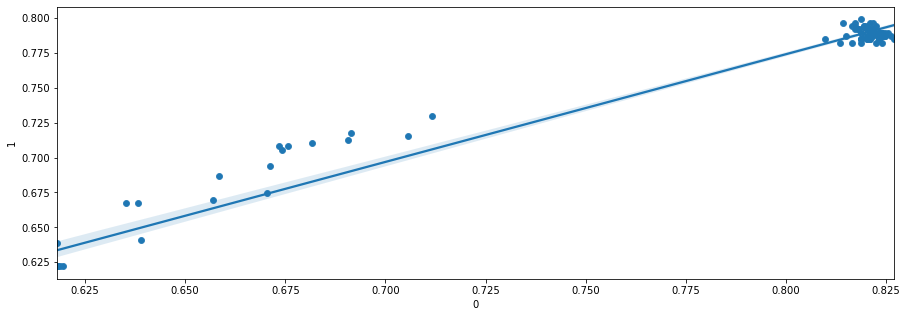

In [146]:
score_boad = pd.DataFrame(score_boad)
score_boad = score_boad.iloc[score_boad[1].sort_values(ascending=False).index]

plt.subplots(figsize=(15, 5))
sns.scatterplot(x=score_boad.iloc[:, 0], y=score_boad.iloc[:,1])
sns.regplot(x=score_boad.iloc[:, 0], y=score_boad.iloc[:,1])
plt.show()

2차

In [147]:
train = pd.read_csv('../../Data/titanic_origintrain.csv')
test = pd.read_csv('../../Data/titanic_origintest.csv')
all_data = pd.concat((train, test), axis=0)

In [148]:
# missing values
all_data['Age'] = all_data.Age.fillna(train.Age.median())
all_data['Fare'] = all_data.Fare.fillna(train.Fare.median())
all_data.dropna(subset=['Embarked'], inplace=True)
cabins = all_data.Cabin
all_data.drop(['Cabin'], axis=1, inplace=True)

# derivative features
all_data['CabinCnt'] = cabins.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['CabinClass'] = cabins.apply(lambda x: str(x)[0])
all_data['IsNumericTicket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['TicketType'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)
all_data['Title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data['Family'] = all_data.SibSp + all_data.Parch

# feature transform
numeric_vars = ['Age', 'SibSp', 'Parch', 'Fare', 'CabinCnt', 'Family']
ordinal_vars = ['Pclass']
nominal_vars = ['Name', 'Sex', 'Ticket', 'Embarked', 'CabinClass', 'IsNumericTicket', 'TicketType', 'Title']
all_data[nominal_vars] = all_data[nominal_vars].astype('str')

train = all_data[all_data.Survived.isnull() == False]
test = all_data[all_data.Survived.isnull() == True]
X_train, y_train = train.drop(['PassengerId', 'Ticket', 'Survived'], axis=1), train.Survived
X_test = test.drop(['PassengerId', 'Ticket', 'Survived'], axis=1)

numeric = X_train.columns[(X_train.dtypes != 'object')].values
scaler = StandardScaler()
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

all_data = pd.concat((X_train, X_test), axis=0)
all_data.Title = all_data.Title.apply(lambda x: 'Others' if x in list(all_data.Title.value_counts()[all_data.Title.value_counts() < 8].index) else x)
all_data.TicketType = all_data.TicketType.apply(lambda x: 'Others' if x in list(all_data.TicketType.value_counts()[all_data.TicketType.value_counts() < 10].index) else x)

data_dummies = pd.get_dummies(all_data)
train_size = X_train.shape[0]
X_train = data_dummies.iloc[:train_size, :]
X_test = data_dummies.iloc[train_size:, :]

y_test = pd.read_csv('../../Data/titanic_ytest.csv').Survived

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

---

In [151]:
score_boad = []
def objective(trial, X, y):
    
    # Random Forest Search Spec.
    grid_param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, 10),
        'max_depth': trial.suggest_int('max_depth', 2, 100),
        'max_features': trial.suggest_int('max_features', 1, 40),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 8, 13),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['entropy']),
        'random_state': 42
    }
    #cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    #cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=.30, random_state=42)
    
    val_scores = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
        xtrain, xtest = X_train.iloc[train_idx, :], X_train.iloc[test_idx, :]
        ytrain, ytest = y_train[train_idx], y_train[test_idx]
        model = RandomForestClassifier(**grid_param).fit(xtrain, ytrain)
        val_score = accuracy_score(ytest, model.predict(xtest))
        val_scores.append(val_score)
        
    val_score = np.array(val_scores).mean()    
    model = RandomForestClassifier(**grid_param)
    test_score = accuracy_score(y_test, model.fit(X_train, y_train).predict(X_test))
    
    score_boad.append((val_score, test_score))
    print(f'val score: {val_score}')
    print(f'test score: {test_score}')
    return val_score

In [152]:
optimize = partial(objective, X=X_train, y=y_train)
study = optuna.create_study(direction='maximize')
# Opimization
# Recevies the function to be optimized and the number of trials
study.optimize(optimize, n_trials=100)

[I 2021-11-22 09:49:31,509] A new study created in memory with name: no-name-dc98197b-a7ff-4218-937c-c0fdf66f6632
[I 2021-11-22 09:49:35,137] Trial 0 finished with value: 0.6187265917602995 and parameters: {'n_estimators': 930, 'max_depth': 63, 'max_features': 29, 'min_samples_leaf': 3, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6187265917602995.


val score: 0.6187265917602995
test score: 0.6291866028708134


[I 2021-11-22 09:49:39,466] Trial 1 finished with value: 0.6209737827715356 and parameters: {'n_estimators': 880, 'max_depth': 74, 'max_features': 31, 'min_samples_leaf': 2, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6209737827715356.


val score: 0.6209737827715356
test score: 0.6339712918660287


[I 2021-11-22 09:49:40,572] Trial 2 finished with value: 0.650187265917603 and parameters: {'n_estimators': 200, 'max_depth': 29, 'max_features': 39, 'min_samples_leaf': 5, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 2 with value: 0.650187265917603.


val score: 0.650187265917603
test score: 0.6794258373205742


[I 2021-11-22 09:49:43,844] Trial 3 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 680, 'max_depth': 51, 'max_features': 30, 'min_samples_leaf': 5, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 2 with value: 0.650187265917603.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:49:47,630] Trial 4 finished with value: 0.6277153558052435 and parameters: {'n_estimators': 950, 'max_depth': 97, 'max_features': 32, 'min_samples_leaf': 5, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 2 with value: 0.650187265917603.


val score: 0.6277153558052435
test score: 0.6483253588516746


[I 2021-11-22 09:49:47,974] Trial 5 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 70, 'max_depth': 32, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 2 with value: 0.650187265917603.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:49:56,291] Trial 6 finished with value: 0.8194756554307115 and parameters: {'n_estimators': 850, 'max_depth': 83, 'max_features': 15, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 6 with value: 0.8194756554307115.


val score: 0.8194756554307115
test score: 0.7942583732057417


[I 2021-11-22 09:50:01,125] Trial 7 finished with value: 0.6426966292134833 and parameters: {'n_estimators': 890, 'max_depth': 92, 'max_features': 33, 'min_samples_leaf': 2, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 6 with value: 0.8194756554307115.


val score: 0.6426966292134833
test score: 0.6746411483253588


[I 2021-11-22 09:50:04,399] Trial 8 finished with value: 0.7071161048689139 and parameters: {'n_estimators': 540, 'max_depth': 83, 'max_features': 40, 'min_samples_leaf': 2, 'min_samples_split': 12, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 6 with value: 0.8194756554307115.


val score: 0.7071161048689139
test score: 0.7129186602870813


[I 2021-11-22 09:50:05,809] Trial 9 finished with value: 0.6958801498127342 and parameters: {'n_estimators': 220, 'max_depth': 26, 'max_features': 38, 'min_samples_leaf': 2, 'min_samples_split': 13, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 6 with value: 0.8194756554307115.


val score: 0.6958801498127342
test score: 0.7200956937799043


[I 2021-11-22 09:50:09,305] Trial 10 finished with value: 0.7153558052434457 and parameters: {'n_estimators': 690, 'max_depth': 7, 'max_features': 13, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 6 with value: 0.8194756554307115.


val score: 0.7153558052434457
test score: 0.7200956937799043


[I 2021-11-22 09:50:12,179] Trial 11 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 690, 'max_depth': 2, 'max_features': 13, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 6 with value: 0.8194756554307115.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:50:16,029] Trial 12 finished with value: 0.7295880149812735 and parameters: {'n_estimators': 710, 'max_depth': 7, 'max_features': 16, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 6 with value: 0.8194756554307115.


val score: 0.7295880149812735
test score: 0.7416267942583732


[I 2021-11-22 09:50:22,214] Trial 13 finished with value: 0.8254681647940074 and parameters: {'n_estimators': 490, 'max_depth': 49, 'max_features': 19, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 13 with value: 0.8254681647940074.


val score: 0.8254681647940074
test score: 0.7870813397129187


[I 2021-11-22 09:50:24,543] Trial 14 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 430, 'max_depth': 53, 'max_features': 23, 'min_samples_leaf': 3, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 13 with value: 0.8254681647940074.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:50:26,890] Trial 15 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 550, 'max_depth': 44, 'max_features': 21, 'min_samples_leaf': 4, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 13 with value: 0.8254681647940074.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:50:30,988] Trial 16 finished with value: 0.8269662921348315 and parameters: {'n_estimators': 380, 'max_depth': 66, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8269662921348315
test score: 0.7870813397129187


[I 2021-11-22 09:50:32,436] Trial 17 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 380, 'max_depth': 69, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:50:35,823] Trial 18 finished with value: 0.8239700374531835 and parameters: {'n_estimators': 380, 'max_depth': 41, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8239700374531835
test score: 0.7918660287081339


[I 2021-11-22 09:50:36,934] Trial 19 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 260, 'max_depth': 62, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:50:39,913] Trial 20 finished with value: 0.7932584269662921 and parameters: {'n_estimators': 460, 'max_depth': 19, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.7932584269662921
test score: 0.7607655502392344


[I 2021-11-22 09:50:42,734] Trial 21 finished with value: 0.8217228464419476 and parameters: {'n_estimators': 330, 'max_depth': 41, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8217228464419476
test score: 0.7942583732057417


[I 2021-11-22 09:50:50,100] Trial 22 finished with value: 0.8247191011235955 and parameters: {'n_estimators': 580, 'max_depth': 39, 'max_features': 26, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8247191011235955
test score: 0.7894736842105263


[I 2021-11-22 09:50:52,781] Trial 23 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 590, 'max_depth': 59, 'max_features': 25, 'min_samples_leaf': 2, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:51:01,087] Trial 24 finished with value: 0.8232209737827716 and parameters: {'n_estimators': 620, 'max_depth': 46, 'max_features': 26, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8232209737827716
test score: 0.7822966507177034


[I 2021-11-22 09:51:03,194] Trial 25 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 500, 'max_depth': 71, 'max_features': 18, 'min_samples_leaf': 2, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:51:12,010] Trial 26 finished with value: 0.8262172284644194 and parameters: {'n_estimators': 790, 'max_depth': 35, 'max_features': 18, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8262172284644194
test score: 0.7918660287081339


[I 2021-11-22 09:51:15,336] Trial 27 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 800, 'max_depth': 20, 'max_features': 19, 'min_samples_leaf': 4, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:51:18,177] Trial 28 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 750, 'max_depth': 53, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:51:29,700] Trial 29 finished with value: 0.8239700374531835 and parameters: {'n_estimators': 990, 'max_depth': 36, 'max_features': 22, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8239700374531835
test score: 0.7870813397129187


[I 2021-11-22 09:51:30,198] Trial 30 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 100, 'max_depth': 58, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:51:34,486] Trial 31 finished with value: 0.8254681647940074 and parameters: {'n_estimators': 330, 'max_depth': 37, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8254681647940074
test score: 0.7822966507177034


[I 2021-11-22 09:51:37,606] Trial 32 finished with value: 0.8239700374531835 and parameters: {'n_estimators': 270, 'max_depth': 23, 'max_features': 34, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8239700374531835
test score: 0.7799043062200957


[I 2021-11-22 09:51:43,398] Trial 33 finished with value: 0.8202247191011237 and parameters: {'n_estimators': 420, 'max_depth': 47, 'max_features': 28, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8202247191011237
test score: 0.784688995215311


[I 2021-11-22 09:51:44,800] Trial 34 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 320, 'max_depth': 32, 'max_features': 19, 'min_samples_leaf': 2, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:51:47,596] Trial 35 finished with value: 0.8254681647940074 and parameters: {'n_estimators': 180, 'max_depth': 66, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8254681647940074
test score: 0.7942583732057417


[I 2021-11-22 09:51:48,309] Trial 36 finished with value: 0.6606741573033708 and parameters: {'n_estimators': 120, 'max_depth': 78, 'max_features': 36, 'min_samples_leaf': 2, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.6606741573033708
test score: 0.7033492822966507


[I 2021-11-22 09:51:50,549] Trial 37 finished with value: 0.8224719101123595 and parameters: {'n_estimators': 140, 'max_depth': 66, 'max_features': 31, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8224719101123595
test score: 0.7870813397129187


[I 2021-11-22 09:51:51,655] Trial 38 finished with value: 0.6187265917602995 and parameters: {'n_estimators': 180, 'max_depth': 77, 'max_features': 27, 'min_samples_leaf': 2, 'min_samples_split': 9, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.6187265917602995
test score: 0.6220095693779905


[I 2021-11-22 09:51:56,716] Trial 39 finished with value: 0.8247191011235955 and parameters: {'n_estimators': 320, 'max_depth': 91, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8247191011235955
test score: 0.7870813397129187


[I 2021-11-22 09:51:59,447] Trial 40 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 510, 'max_depth': 34, 'max_features': 24, 'min_samples_leaf': 2, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:52:02,859] Trial 41 finished with value: 0.8224719101123596 and parameters: {'n_estimators': 260, 'max_depth': 56, 'max_features': 16, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8224719101123596
test score: 0.7822966507177034


[I 2021-11-22 09:52:03,783] Trial 42 finished with value: 0.8209737827715357 and parameters: {'n_estimators': 50, 'max_depth': 50, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8209737827715357
test score: 0.7822966507177034


[I 2021-11-22 09:52:08,661] Trial 43 finished with value: 0.8254681647940074 and parameters: {'n_estimators': 380, 'max_depth': 64, 'max_features': 12, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8254681647940074
test score: 0.7870813397129187


[I 2021-11-22 09:52:13,511] Trial 44 finished with value: 0.8209737827715357 and parameters: {'n_estimators': 370, 'max_depth': 64, 'max_features': 13, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.8209737827715357
test score: 0.784688995215311


[I 2021-11-22 09:52:14,302] Trial 45 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 160, 'max_depth': 84, 'max_features': 11, 'min_samples_leaf': 2, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 16 with value: 0.8269662921348315.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:52:16,573] Trial 46 finished with value: 0.8292134831460674 and parameters: {'n_estimators': 210, 'max_depth': 73, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8292134831460674
test score: 0.7918660287081339


[I 2021-11-22 09:52:18,766] Trial 47 finished with value: 0.8089887640449438 and parameters: {'n_estimators': 220, 'max_depth': 72, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8089887640449438
test score: 0.7870813397129187


[I 2021-11-22 09:52:19,664] Trial 48 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 210, 'max_depth': 28, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:52:22,989] Trial 49 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 900, 'max_depth': 78, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:52:26,394] Trial 50 finished with value: 0.8179775280898877 and parameters: {'n_estimators': 280, 'max_depth': 100, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8179775280898877
test score: 0.7822966507177034


[I 2021-11-22 09:52:30,545] Trial 51 finished with value: 0.8224719101123595 and parameters: {'n_estimators': 410, 'max_depth': 67, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8224719101123595
test score: 0.7966507177033493


[I 2021-11-22 09:52:36,349] Trial 52 finished with value: 0.8217228464419476 and parameters: {'n_estimators': 480, 'max_depth': 48, 'max_features': 17, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8217228464419476
test score: 0.7894736842105263


[I 2021-11-22 09:52:42,071] Trial 53 finished with value: 0.8224719101123595 and parameters: {'n_estimators': 460, 'max_depth': 61, 'max_features': 13, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8224719101123595
test score: 0.7870813397129187


[I 2021-11-22 09:52:46,868] Trial 54 finished with value: 0.8217228464419476 and parameters: {'n_estimators': 350, 'max_depth': 85, 'max_features': 11, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8217228464419476
test score: 0.784688995215311


[I 2021-11-22 09:52:53,740] Trial 55 finished with value: 0.8254681647940074 and parameters: {'n_estimators': 540, 'max_depth': 56, 'max_features': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8254681647940074
test score: 0.7870813397129187


[I 2021-11-22 09:53:02,180] Trial 56 finished with value: 0.8232209737827715 and parameters: {'n_estimators': 630, 'max_depth': 55, 'max_features': 21, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8232209737827715
test score: 0.7822966507177034


[I 2021-11-22 09:53:05,591] Trial 57 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 810, 'max_depth': 12, 'max_features': 23, 'min_samples_leaf': 2, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:53:11,976] Trial 58 finished with value: 0.8217228464419476 and parameters: {'n_estimators': 550, 'max_depth': 75, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8217228464419476
test score: 0.7822966507177034


[I 2021-11-22 09:53:18,893] Trial 59 finished with value: 0.8239700374531835 and parameters: {'n_estimators': 660, 'max_depth': 38, 'max_features': 15, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8239700374531835
test score: 0.7894736842105263


[I 2021-11-22 09:53:19,876] Trial 60 finished with value: 0.8209737827715354 and parameters: {'n_estimators': 80, 'max_depth': 68, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8209737827715354
test score: 0.8014354066985646


[I 2021-11-22 09:53:23,787] Trial 61 finished with value: 0.8224719101123595 and parameters: {'n_estimators': 300, 'max_depth': 64, 'max_features': 14, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8224719101123595
test score: 0.7822966507177034


[I 2021-11-22 09:53:26,808] Trial 62 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 730, 'max_depth': 59, 'max_features': 19, 'min_samples_leaf': 4, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:53:29,125] Trial 63 finished with value: 0.8187265917602996 and parameters: {'n_estimators': 240, 'max_depth': 43, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8187265917602996
test score: 0.784688995215311


[I 2021-11-22 09:53:34,008] Trial 64 finished with value: 0.8209737827715357 and parameters: {'n_estimators': 400, 'max_depth': 72, 'max_features': 11, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8209737827715357
test score: 0.784688995215311


[I 2021-11-22 09:53:41,042] Trial 65 finished with value: 0.8194756554307115 and parameters: {'n_estimators': 450, 'max_depth': 80, 'max_features': 35, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8194756554307115
test score: 0.7894736842105263


[I 2021-11-22 09:53:43,380] Trial 66 finished with value: 0.8224719101123596 and parameters: {'n_estimators': 180, 'max_depth': 53, 'max_features': 17, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8224719101123596
test score: 0.7918660287081339


[I 2021-11-22 09:53:45,268] Trial 67 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 350, 'max_depth': 50, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:53:47,862] Trial 68 finished with value: 0.8187265917602996 and parameters: {'n_estimators': 300, 'max_depth': 61, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8187265917602996
test score: 0.7894736842105263


[I 2021-11-22 09:53:51,030] Trial 69 finished with value: 0.8209737827715357 and parameters: {'n_estimators': 240, 'max_depth': 69, 'max_features': 14, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8209737827715357
test score: 0.784688995215311


[I 2021-11-22 09:53:55,058] Trial 70 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 960, 'max_depth': 44, 'max_features': 24, 'min_samples_leaf': 2, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:54:00,220] Trial 71 finished with value: 0.8277153558052432 and parameters: {'n_estimators': 520, 'max_depth': 31, 'max_features': 17, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8277153558052432
test score: 0.7822966507177034


[I 2021-11-22 09:54:05,010] Trial 72 finished with value: 0.8247191011235955 and parameters: {'n_estimators': 530, 'max_depth': 26, 'max_features': 17, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8247191011235955
test score: 0.7894736842105263


[I 2021-11-22 09:54:10,292] Trial 73 finished with value: 0.8209737827715357 and parameters: {'n_estimators': 590, 'max_depth': 30, 'max_features': 12, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8209737827715357
test score: 0.7822966507177034


[I 2021-11-22 09:54:14,820] Trial 74 finished with value: 0.8269662921348313 and parameters: {'n_estimators': 440, 'max_depth': 34, 'max_features': 16, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8269662921348313
test score: 0.7894736842105263


[I 2021-11-22 09:54:20,733] Trial 75 finished with value: 0.8202247191011235 and parameters: {'n_estimators': 500, 'max_depth': 36, 'max_features': 21, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8202247191011235
test score: 0.7894736842105263


[I 2021-11-22 09:54:24,036] Trial 76 finished with value: 0.8142322097378276 and parameters: {'n_estimators': 440, 'max_depth': 18, 'max_features': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8142322097378276
test score: 0.7870813397129187


[I 2021-11-22 09:54:27,736] Trial 77 finished with value: 0.8247191011235955 and parameters: {'n_estimators': 390, 'max_depth': 23, 'max_features': 18, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8247191011235955
test score: 0.784688995215311


[I 2021-11-22 09:54:29,814] Trial 78 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 480, 'max_depth': 33, 'max_features': 18, 'min_samples_leaf': 2, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:54:34,220] Trial 79 finished with value: 0.8202247191011235 and parameters: {'n_estimators': 420, 'max_depth': 40, 'max_features': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8202247191011235
test score: 0.7870813397129187


[I 2021-11-22 09:54:36,363] Trial 80 finished with value: 0.7438202247191011 and parameters: {'n_estimators': 340, 'max_depth': 31, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.7438202247191011
test score: 0.7200956937799043


[I 2021-11-22 09:54:40,487] Trial 81 finished with value: 0.8239700374531835 and parameters: {'n_estimators': 370, 'max_depth': 36, 'max_features': 16, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8239700374531835
test score: 0.7894736842105263


[I 2021-11-22 09:54:41,468] Trial 82 finished with value: 0.7835205992509364 and parameters: {'n_estimators': 130, 'max_depth': 27, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.7835205992509364
test score: 0.7703349282296651


[I 2021-11-22 09:54:48,211] Trial 83 finished with value: 0.8217228464419476 and parameters: {'n_estimators': 480, 'max_depth': 74, 'max_features': 19, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8217228464419476
test score: 0.7870813397129187


[I 2021-11-22 09:54:56,122] Trial 84 finished with value: 0.8232209737827716 and parameters: {'n_estimators': 620, 'max_depth': 64, 'max_features': 14, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8232209737827716
test score: 0.7822966507177034


[I 2021-11-22 09:55:00,485] Trial 85 finished with value: 0.8239700374531835 and parameters: {'n_estimators': 300, 'max_depth': 56, 'max_features': 28, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8239700374531835
test score: 0.7822966507177034


[I 2021-11-22 09:55:02,892] Trial 86 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 570, 'max_depth': 46, 'max_features': 22, 'min_samples_leaf': 3, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:55:05,091] Trial 87 finished with value: 0.8209737827715354 and parameters: {'n_estimators': 180, 'max_depth': 71, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8209737827715354
test score: 0.7799043062200957


[I 2021-11-22 09:55:15,422] Trial 88 finished with value: 0.8224719101123595 and parameters: {'n_estimators': 810, 'max_depth': 65, 'max_features': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8224719101123595
test score: 0.7822966507177034


[I 2021-11-22 09:55:21,248] Trial 89 finished with value: 0.8239700374531835 and parameters: {'n_estimators': 430, 'max_depth': 42, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8239700374531835
test score: 0.7822966507177034


[I 2021-11-22 09:55:27,939] Trial 90 finished with value: 0.8202247191011237 and parameters: {'n_estimators': 520, 'max_depth': 81, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8202247191011237
test score: 0.784688995215311


[I 2021-11-22 09:55:32,985] Trial 91 finished with value: 0.8224719101123595 and parameters: {'n_estimators': 380, 'max_depth': 62, 'max_features': 16, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8224719101123595
test score: 0.7870813397129187


[I 2021-11-22 09:55:43,873] Trial 92 finished with value: 0.8224719101123595 and parameters: {'n_estimators': 860, 'max_depth': 38, 'max_features': 26, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8224719101123595
test score: 0.777511961722488


[I 2021-11-22 09:55:48,299] Trial 93 finished with value: 0.8232209737827715 and parameters: {'n_estimators': 470, 'max_depth': 35, 'max_features': 12, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8232209737827715
test score: 0.784688995215311


[I 2021-11-22 09:55:53,593] Trial 94 finished with value: 0.8232209737827716 and parameters: {'n_estimators': 560, 'max_depth': 58, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8232209737827716
test score: 0.8014354066985646


[I 2021-11-22 09:55:58,628] Trial 95 finished with value: 0.8172284644194757 and parameters: {'n_estimators': 500, 'max_depth': 24, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8172284644194757
test score: 0.7966507177033493


[I 2021-11-22 09:55:59,743] Trial 96 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 240, 'max_depth': 52, 'max_features': 17, 'min_samples_leaf': 5, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.6179775280898876
test score: 0.6220095693779905


[I 2021-11-22 09:56:02,319] Trial 97 finished with value: 0.8157303370786517 and parameters: {'n_estimators': 150, 'max_depth': 70, 'max_features': 37, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8157303370786517
test score: 0.7894736842105263


[I 2021-11-22 09:56:07,388] Trial 98 finished with value: 0.8209737827715357 and parameters: {'n_estimators': 360, 'max_depth': 74, 'max_features': 18, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.8209737827715357
test score: 0.7894736842105263


[I 2021-11-22 09:56:09,608] Trial 99 finished with value: 0.6179775280898876 and parameters: {'n_estimators': 540, 'max_depth': 66, 'max_features': 16, 'min_samples_leaf': 3, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 46 with value: 0.8292134831460674.


val score: 0.6179775280898876
test score: 0.6220095693779905


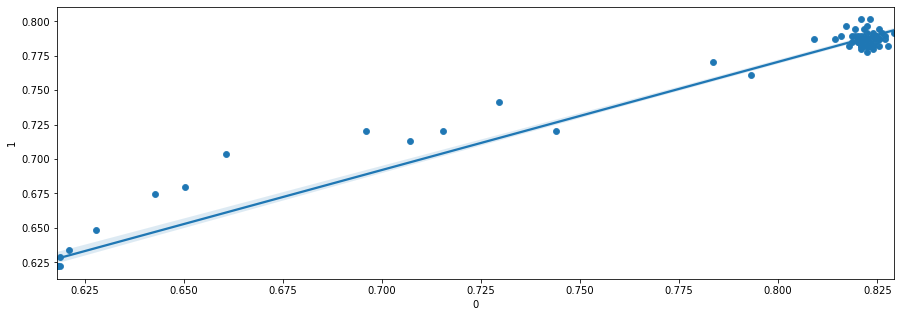

In [173]:
score_boad = pd.DataFrame(score_boad)
score_boad = score_boad.iloc[score_boad[0].sort_values(ascending=False).index]

plt.subplots(figsize=(15, 5))
sns.scatterplot(x=score_boad.iloc[:, 0], y=score_boad.iloc[:,1])
sns.regplot(x=score_boad.iloc[:, 0], y=score_boad.iloc[:,1])
plt.show()

시도3 - Stratified + No Scale

In [180]:
train = pd.read_csv('../../Data/titanic_origintrain.csv')
test = pd.read_csv('../../Data/titanic_origintest.csv')
all_data = pd.concat((train, test), axis=0)

In [181]:
# missing values
all_data['Age'] = all_data.Age.fillna(train.Age.median())
all_data['Fare'] = all_data.Fare.fillna(train.Fare.median())
all_data.dropna(subset=['Embarked'], inplace=True)
cabins = all_data.Cabin
all_data.drop(['Cabin'], axis=1, inplace=True)

# derivative features
all_data['CabinCnt'] = cabins.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['CabinClass'] = cabins.apply(lambda x: str(x)[0])
all_data['IsNumericTicket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['TicketType'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)
all_data['Title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data['Family'] = all_data.SibSp + all_data.Parch

# feature transform
numeric_vars = ['Age', 'SibSp', 'Parch', 'Fare', 'CabinCnt', 'Family']
ordinal_vars = ['Pclass']
nominal_vars = ['Name', 'Sex', 'Ticket', 'Embarked', 'CabinClass', 'IsNumericTicket', 'TicketType', 'Title']
all_data[nominal_vars] = all_data[nominal_vars].astype('str')

train = all_data[all_data.Survived.isnull() == False]
test = all_data[all_data.Survived.isnull() == True]
X_train, y_train = train.drop(['PassengerId', 'Ticket', 'Survived'], axis=1), train.Survived
X_test = test.drop(['PassengerId', 'Ticket', 'Survived'], axis=1)

numeric = X_train.columns[(X_train.dtypes != 'object')].values
#scaler = StandardScaler()
#X_train[numeric] = scaler.fit_transform(X_train[numeric])
#X_test[numeric] = scaler.transform(X_test[numeric])

all_data = pd.concat((X_train, X_test), axis=0)
all_data.Title = all_data.Title.apply(lambda x: 'Others' if x in list(all_data.Title.value_counts()[all_data.Title.value_counts() < 8].index) else x)
all_data.TicketType = all_data.TicketType.apply(lambda x: 'Others' if x in list(all_data.TicketType.value_counts()[all_data.TicketType.value_counts() < 10].index) else x)

data_dummies = pd.get_dummies(all_data)
train_size = X_train.shape[0]
X_train = data_dummies.iloc[:train_size, :]
X_test = data_dummies.iloc[train_size:, :]

y_test = pd.read_csv('../../Data/titanic_ytest.csv').Survived

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [182]:
score_board = []
def objective(trial, X, y):
    
    # Random Forest Search Spec.
    grid_param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, 10),
        'max_depth': trial.suggest_int('max_depth', 2, 100),
        'max_features': trial.suggest_int('max_features', 1, 40),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 8, 13),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['entropy']),
        'random_state': 42
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    #cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
    #cv = StratifiedShuffleSplit(n_splits=5, test_size=.30, random_state=42)
    
    val_scores = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
        xtrain, xtest = X_train.iloc[train_idx, :], X_train.iloc[test_idx, :]
        ytrain, ytest = y_train[train_idx], y_train[test_idx]
        model = RandomForestClassifier(**grid_param).fit(xtrain, ytrain)
        val_score = accuracy_score(ytest, model.predict(xtest))
        val_scores.append(val_score)
        
    val_score = np.array(val_scores).mean()    
    val_std = np.array(val_scores).std()
    model = RandomForestClassifier(**grid_param)
    test_score = accuracy_score(y_test, model.fit(X_train, y_train).predict(X_test))
    
    score_board.append((val_score, val_std, test_score))
    print(f'val score: {val_score}')
    print(f'val std: {val_std}')
    print(f'test score: {test_score}')
    return val_score

In [183]:
optimize = partial(objective, X=X_train, y=y_train)
study = optuna.create_study(direction='maximize')
# Opimization
# Recevies the function to be optimized and the number of trials
study.optimize(optimize, n_trials=100)

[I 2021-11-22 10:56:56,057] A new study created in memory with name: no-name-2bc426ce-0c75-4393-8ef0-6fe9c65f6a9f
[I 2021-11-22 10:56:56,716] Trial 0 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 170, 'max_depth': 26, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6175458642798197.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 10:57:00,779] Trial 1 finished with value: 0.6209166507966736 and parameters: {'n_estimators': 970, 'max_depth': 71, 'max_features': 31, 'min_samples_leaf': 4, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6209166507966736.


val score: 0.6209166507966736
val std: 0.00335115336007477
test score: 0.6363636363636364


[I 2021-11-22 10:57:05,338] Trial 2 finished with value: 0.645692883895131 and parameters: {'n_estimators': 910, 'max_depth': 35, 'max_features': 34, 'min_samples_leaf': 4, 'min_samples_split': 11, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 2 with value: 0.645692883895131.


val score: 0.645692883895131
val std: 0.018704106350837107
test score: 0.6674641148325359


[I 2021-11-22 10:57:09,684] Trial 3 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 950, 'max_depth': 53, 'max_features': 17, 'min_samples_leaf': 5, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 2 with value: 0.645692883895131.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 10:57:10,328] Trial 4 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 120, 'max_depth': 25, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 2 with value: 0.645692883895131.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 10:57:13,359] Trial 5 finished with value: 0.8425188852916904 and parameters: {'n_estimators': 190, 'max_depth': 69, 'max_features': 38, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.8425188852916904
val std: 0.02775303868689586
test score: 0.7799043062200957


[I 2021-11-22 10:57:16,287] Trial 6 finished with value: 0.6569478829429315 and parameters: {'n_estimators': 580, 'max_depth': 29, 'max_features': 36, 'min_samples_leaf': 4, 'min_samples_split': 12, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.6569478829429315
val std: 0.022034541142442687
test score: 0.6674641148325359


[I 2021-11-22 10:57:17,407] Trial 7 finished with value: 0.6940582746143591 and parameters: {'n_estimators': 200, 'max_depth': 37, 'max_features': 40, 'min_samples_leaf': 5, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.6940582746143591
val std: 0.028789829522636482
test score: 0.7081339712918661


[I 2021-11-22 10:57:19,568] Trial 8 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 450, 'max_depth': 72, 'max_features': 21, 'min_samples_leaf': 2, 'min_samples_split': 13, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 10:57:19,911] Trial 9 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 60, 'max_depth': 49, 'max_features': 14, 'min_samples_leaf': 4, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 10:57:25,477] Trial 10 finished with value: 0.8391480987748364 and parameters: {'n_estimators': 350, 'max_depth': 91, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.8391480987748364
val std: 0.02647375440456169
test score: 0.7894736842105263


[I 2021-11-22 10:57:32,303] Trial 11 finished with value: 0.8391417507776296 and parameters: {'n_estimators': 380, 'max_depth': 98, 'max_features': 26, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.8391417507776296
val std: 0.025293698227695515
test score: 0.7799043062200957


[I 2021-11-22 10:57:38,074] Trial 12 finished with value: 0.8369072557608075 and parameters: {'n_estimators': 320, 'max_depth': 96, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.8369072557608075
val std: 0.026279701017622854
test score: 0.7918660287081339


[I 2021-11-22 10:57:41,425] Trial 13 finished with value: 0.7041642861677141 and parameters: {'n_estimators': 620, 'max_depth': 81, 'max_features': 39, 'min_samples_leaf': 2, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.7041642861677141
val std: 0.023152135327970832
test score: 0.715311004784689


[I 2021-11-22 10:57:42,736] Trial 14 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 270, 'max_depth': 6, 'max_features': 28, 'min_samples_leaf': 2, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 10:57:53,809] Trial 15 finished with value: 0.8380308512664254 and parameters: {'n_estimators': 700, 'max_depth': 83, 'max_features': 22, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.8380308512664254
val std: 0.024651268368596668
test score: 0.784688995215311


[I 2021-11-22 10:57:55,832] Trial 16 finished with value: 0.6288072113248271 and parameters: {'n_estimators': 400, 'max_depth': 63, 'max_features': 32, 'min_samples_leaf': 3, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.6288072113248271
val std: 0.008938859185599793
test score: 0.6483253588516746


[I 2021-11-22 10:57:57,099] Trial 17 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 270, 'max_depth': 87, 'max_features': 24, 'min_samples_leaf': 2, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 10:58:10,084] Trial 18 finished with value: 0.8402780422776613 and parameters: {'n_estimators': 780, 'max_depth': 59, 'max_features': 36, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.8402780422776613
val std: 0.0266829090146266
test score: 0.784688995215311


[I 2021-11-22 10:58:13,938] Trial 19 finished with value: 0.6861804100806195 and parameters: {'n_estimators': 760, 'max_depth': 55, 'max_features': 36, 'min_samples_leaf': 3, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.6861804100806195
val std: 0.020595063179982286
test score: 0.7105263157894737


[I 2021-11-22 10:58:18,353] Trial 20 finished with value: 0.704170634164921 and parameters: {'n_estimators': 830, 'max_depth': 68, 'max_features': 40, 'min_samples_leaf': 3, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.704170634164921
val std: 0.018177327892819135
test score: 0.7320574162679426


[I 2021-11-22 10:58:26,486] Trial 21 finished with value: 0.8402716942804546 and parameters: {'n_estimators': 500, 'max_depth': 78, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.8402716942804546
val std: 0.025261349009982777
test score: 0.7870813397129187


[I 2021-11-22 10:58:34,584] Trial 22 finished with value: 0.8402780422776616 and parameters: {'n_estimators': 480, 'max_depth': 77, 'max_features': 31, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.8402780422776616
val std: 0.024461308551686243
test score: 0.7799043062200957


[I 2021-11-22 10:58:37,649] Trial 23 finished with value: 0.6895575445946803 and parameters: {'n_estimators': 600, 'max_depth': 60, 'max_features': 36, 'min_samples_leaf': 2, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8425188852916904.


val score: 0.6895575445946803
val std: 0.0257434368618794
test score: 0.7057416267942583


[I 2021-11-22 10:58:48,794] Trial 24 finished with value: 0.8436424807973084 and parameters: {'n_estimators': 710, 'max_depth': 45, 'max_features': 34, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8436424807973084
val std: 0.023951737947411764
test score: 0.7870813397129187


[I 2021-11-22 10:58:59,850] Trial 25 finished with value: 0.8413952897860725 and parameters: {'n_estimators': 700, 'max_depth': 43, 'max_features': 33, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8413952897860725
val std: 0.02419734634659812
test score: 0.7822966507177034


[I 2021-11-22 10:59:03,421] Trial 26 finished with value: 0.6479337269091602 and parameters: {'n_estimators': 700, 'max_depth': 45, 'max_features': 33, 'min_samples_leaf': 2, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6479337269091602
val std: 0.009900787908199439
test score: 0.6555023923444976


[I 2021-11-22 10:59:12,440] Trial 27 finished with value: 0.834641020757951 and parameters: {'n_estimators': 850, 'max_depth': 16, 'max_features': 38, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.834641020757951
val std: 0.014954032949458254
test score: 0.784688995215311


[I 2021-11-22 10:59:15,274] Trial 28 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 670, 'max_depth': 40, 'max_features': 17, 'min_samples_leaf': 2, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 10:59:17,553] Trial 29 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 550, 'max_depth': 44, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 10:59:27,185] Trial 30 finished with value: 0.834641020757951 and parameters: {'n_estimators': 760, 'max_depth': 24, 'max_features': 34, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.834641020757951
val std: 0.021528859814212594
test score: 0.7894736842105263


[I 2021-11-22 10:59:35,117] Trial 31 finished with value: 0.8425188852916905 and parameters: {'n_estimators': 480, 'max_depth': 65, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8425188852916905
val std: 0.02775303868689586
test score: 0.784688995215311


[I 2021-11-22 10:59:45,494] Trial 32 finished with value: 0.8402716942804546 and parameters: {'n_estimators': 640, 'max_depth': 64, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8402716942804546
val std: 0.02764746715033133
test score: 0.784688995215311


[I 2021-11-22 10:59:48,370] Trial 33 finished with value: 0.8391544467720433 and parameters: {'n_estimators': 190, 'max_depth': 52, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8391544467720433
val std: 0.023126761850018274
test score: 0.7918660287081339


[I 2021-11-22 10:59:52,444] Trial 34 finished with value: 0.6580206944708944 and parameters: {'n_estimators': 890, 'max_depth': 71, 'max_features': 34, 'min_samples_leaf': 2, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6580206944708944
val std: 0.013580806772821448
test score: 0.6818181818181818


[I 2021-11-22 10:59:57,863] Trial 35 finished with value: 0.8324001777439218 and parameters: {'n_estimators': 540, 'max_depth': 32, 'max_features': 24, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8324001777439218
val std: 0.0228285365421766
test score: 0.7966507177033493


[I 2021-11-22 11:00:05,588] Trial 36 finished with value: 0.8413952897860725 and parameters: {'n_estimators': 440, 'max_depth': 47, 'max_features': 37, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8413952897860725
val std: 0.02419734634659812
test score: 0.7894736842105263


[I 2021-11-22 11:00:08,108] Trial 37 finished with value: 0.699676252142449 and parameters: {'n_estimators': 430, 'max_depth': 56, 'max_features': 38, 'min_samples_leaf': 2, 'min_samples_split': 13, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.699676252142449
val std: 0.029926831495026195
test score: 0.7200956937799043


[I 2021-11-22 11:00:13,535] Trial 38 finished with value: 0.8188979876848854 and parameters: {'n_estimators': 710, 'max_depth': 39, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8188979876848854
val std: 0.025714610756701454
test score: 0.7751196172248804


[I 2021-11-22 11:00:14,183] Trial 39 finished with value: 0.6850314225861741 and parameters: {'n_estimators': 110, 'max_depth': 50, 'max_features': 37, 'min_samples_leaf': 2, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6850314225861741
val std: 0.03715747770791961
test score: 0.7009569377990431


[I 2021-11-22 11:00:17,692] Trial 40 finished with value: 0.8402653462832476 and parameters: {'n_estimators': 270, 'max_depth': 66, 'max_features': 35, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8402653462832476
val std: 0.024022104752229725
test score: 0.7966507177033493


[I 2021-11-22 11:00:24,970] Trial 41 finished with value: 0.8414016377832795 and parameters: {'n_estimators': 470, 'max_depth': 45, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8414016377832795
val std: 0.025430582300277692
test score: 0.7870813397129187


[I 2021-11-22 11:00:32,964] Trial 42 finished with value: 0.8425188852916905 and parameters: {'n_estimators': 460, 'max_depth': 47, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8425188852916905
val std: 0.025376849101727467
test score: 0.7870813397129187


[I 2021-11-22 11:00:40,404] Trial 43 finished with value: 0.8425315812861042 and parameters: {'n_estimators': 490, 'max_depth': 58, 'max_features': 25, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8425315812861042
val std: 0.025797431209615536
test score: 0.7822966507177034


[I 2021-11-22 11:00:45,155] Trial 44 finished with value: 0.8357836602551896 and parameters: {'n_estimators': 320, 'max_depth': 74, 'max_features': 18, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8357836602551896
val std: 0.01980644711140174
test score: 0.7870813397129187


[I 2021-11-22 11:00:47,605] Trial 45 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 520, 'max_depth': 34, 'max_features': 26, 'min_samples_leaf': 5, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 11:00:50,254] Trial 46 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 570, 'max_depth': 59, 'max_features': 24, 'min_samples_leaf': 2, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 11:00:54,361] Trial 47 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 960, 'max_depth': 69, 'max_features': 20, 'min_samples_leaf': 4, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 11:01:00,584] Trial 48 finished with value: 0.8402716942804546 and parameters: {'n_estimators': 380, 'max_depth': 54, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8402716942804546
val std: 0.030263483987440054
test score: 0.7942583732057417


[I 2021-11-22 11:01:03,152] Trial 49 finished with value: 0.8312765822383037 and parameters: {'n_estimators': 220, 'max_depth': 64, 'max_features': 13, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8312765822383037
val std: 0.01874987551102823
test score: 0.7894736842105263


[I 2021-11-22 11:01:03,898] Trial 50 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 130, 'max_depth': 49, 'max_features': 27, 'min_samples_leaf': 2, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 11:01:11,272] Trial 51 finished with value: 0.8391480987748364 and parameters: {'n_estimators': 480, 'max_depth': 41, 'max_features': 31, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8391480987748364
val std: 0.02205085726295948
test score: 0.784688995215311


[I 2021-11-22 11:01:18,418] Trial 52 finished with value: 0.8425252332888974 and parameters: {'n_estimators': 460, 'max_depth': 58, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8425252332888974
val std: 0.029052444057436833
test score: 0.784688995215311


[I 2021-11-22 11:01:24,594] Trial 53 finished with value: 0.8414016377832795 and parameters: {'n_estimators': 410, 'max_depth': 60, 'max_features': 25, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8414016377832795
val std: 0.025430582300277692
test score: 0.7799043062200957


[I 2021-11-22 11:01:29,950] Trial 54 finished with value: 0.8402716942804546 and parameters: {'n_estimators': 350, 'max_depth': 57, 'max_features': 28, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8402716942804546
val std: 0.025261349009982777
test score: 0.7870813397129187


[I 2021-11-22 11:01:37,823] Trial 55 finished with value: 0.8402780422776613 and parameters: {'n_estimators': 510, 'max_depth': 74, 'max_features': 22, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8402780422776613
val std: 0.021728067793439578
test score: 0.7822966507177034


[I 2021-11-22 11:01:47,541] Trial 56 finished with value: 0.8391480987748364 and parameters: {'n_estimators': 600, 'max_depth': 53, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8391480987748364
val std: 0.024232986915586913
test score: 0.7870813397129187


[I 2021-11-22 11:01:48,005] Trial 57 finished with value: 0.6220402463022916 and parameters: {'n_estimators': 70, 'max_depth': 62, 'max_features': 29, 'min_samples_leaf': 2, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6220402463022916
val std: 0.005909709245048318
test score: 0.6363636363636364


[I 2021-11-22 11:01:54,792] Trial 58 finished with value: 0.8425188852916904 and parameters: {'n_estimators': 360, 'max_depth': 81, 'max_features': 40, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8425188852916904
val std: 0.02775303868689586
test score: 0.7799043062200957


[I 2021-11-22 11:02:01,269] Trial 59 finished with value: 0.8425252332888974 and parameters: {'n_estimators': 370, 'max_depth': 85, 'max_features': 26, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8425252332888974
val std: 0.02406089077858638
test score: 0.7870813397129187


[I 2021-11-22 11:02:02,854] Trial 60 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 310, 'max_depth': 93, 'max_features': 26, 'min_samples_leaf': 2, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 11:02:08,725] Trial 61 finished with value: 0.8380308512664254 and parameters: {'n_estimators': 360, 'max_depth': 88, 'max_features': 23, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8380308512664254
val std: 0.024393859136637757
test score: 0.7799043062200957


[I 2021-11-22 11:02:16,081] Trial 62 finished with value: 0.8425188852916905 and parameters: {'n_estimators': 400, 'max_depth': 83, 'max_features': 40, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8425188852916905
val std: 0.025376849101727467
test score: 0.7799043062200957


[I 2021-11-22 11:02:22,746] Trial 63 finished with value: 0.8380181552720117 and parameters: {'n_estimators': 410, 'max_depth': 85, 'max_features': 28, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8380181552720117
val std: 0.02645667948968401
test score: 0.7894736842105263


[I 2021-11-22 11:02:29,393] Trial 64 finished with value: 0.8380371992636324 and parameters: {'n_estimators': 450, 'max_depth': 90, 'max_features': 20, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8380371992636324
val std: 0.02383435333213208
test score: 0.7870813397129187


[I 2021-11-22 11:02:37,584] Trial 65 finished with value: 0.8402716942804546 and parameters: {'n_estimators': 500, 'max_depth': 97, 'max_features': 31, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8402716942804546
val std: 0.025261349009982777
test score: 0.784688995215311


[I 2021-11-22 11:02:52,848] Trial 66 finished with value: 0.8380308512664254 and parameters: {'n_estimators': 1000, 'max_depth': 77, 'max_features': 26, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8380308512664254
val std: 0.022227528309700373
test score: 0.784688995215311


[I 2021-11-22 11:03:00,610] Trial 67 finished with value: 0.8391417507776296 and parameters: {'n_estimators': 560, 'max_depth': 37, 'max_features': 33, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8391417507776296
val std: 0.02767702758712032
test score: 0.784688995215311


[I 2021-11-22 11:03:07,860] Trial 68 finished with value: 0.8391480987748364 and parameters: {'n_estimators': 480, 'max_depth': 67, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8391480987748364
val std: 0.02647375440456169
test score: 0.784688995215311


[I 2021-11-22 11:03:13,928] Trial 69 finished with value: 0.8414016377832795 and parameters: {'n_estimators': 390, 'max_depth': 100, 'max_features': 25, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8414016377832795
val std: 0.0280283048142077
test score: 0.7799043062200957


[I 2021-11-22 11:03:16,262] Trial 70 finished with value: 0.6794451850441185 and parameters: {'n_estimators': 420, 'max_depth': 28, 'max_features': 35, 'min_samples_leaf': 2, 'min_samples_split': 12, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6794451850441185
val std: 0.03598411700746009
test score: 0.6913875598086124


[I 2021-11-22 11:03:21,603] Trial 71 finished with value: 0.8413952897860725 and parameters: {'n_estimators': 310, 'max_depth': 81, 'max_features': 40, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8413952897860725
val std: 0.026678797878497404
test score: 0.7799043062200957


[I 2021-11-22 11:03:29,108] Trial 72 finished with value: 0.8391417507776296 and parameters: {'n_estimators': 450, 'max_depth': 83, 'max_features': 39, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8391417507776296
val std: 0.025293698227695515
test score: 0.784688995215311


[I 2021-11-22 11:03:35,167] Trial 73 finished with value: 0.8357709642607757 and parameters: {'n_estimators': 370, 'max_depth': 78, 'max_features': 37, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8357709642607757
val std: 0.022011568412246225
test score: 0.7822966507177034


[I 2021-11-22 11:03:39,331] Trial 74 finished with value: 0.8380181552720117 and parameters: {'n_estimators': 240, 'max_depth': 49, 'max_features': 35, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8380181552720117
val std: 0.019279899013122107
test score: 0.784688995215311


[I 2021-11-22 11:03:45,581] Trial 75 finished with value: 0.834641020757951 and parameters: {'n_estimators': 340, 'max_depth': 87, 'max_features': 39, 'min_samples_leaf': 1, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.834641020757951
val std: 0.024284531927227057
test score: 0.7822966507177034


[I 2021-11-22 11:03:48,090] Trial 76 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 540, 'max_depth': 92, 'max_features': 28, 'min_samples_leaf': 5, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 11:03:52,861] Trial 77 finished with value: 0.8357709642607757 and parameters: {'n_estimators': 280, 'max_depth': 74, 'max_features': 34, 'min_samples_leaf': 1, 'min_samples_split': 12, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8357709642607757
val std: 0.021430347798439886
test score: 0.777511961722488


[I 2021-11-22 11:04:00,658] Trial 78 finished with value: 0.8413952897860725 and parameters: {'n_estimators': 470, 'max_depth': 81, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8413952897860725
val std: 0.023935055914176932
test score: 0.7799043062200957


[I 2021-11-22 11:04:03,602] Trial 79 finished with value: 0.6175458642798197 and parameters: {'n_estimators': 650, 'max_depth': 47, 'max_features': 27, 'min_samples_leaf': 2, 'min_samples_split': 11, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.6175458642798197
val std: 0.0008633276201358342
test score: 0.6220095693779905


[I 2021-11-22 11:04:11,112] Trial 80 finished with value: 0.8391480987748364 and parameters: {'n_estimators': 440, 'max_depth': 57, 'max_features': 38, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8391480987748364
val std: 0.023971086463666125
test score: 0.7822966507177034


[I 2021-11-22 11:04:21,652] Trial 81 finished with value: 0.8380181552720117 and parameters: {'n_estimators': 590, 'max_depth': 70, 'max_features': 38, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8380181552720117
val std: 0.02645667948968401
test score: 0.7870813397129187


[I 2021-11-22 11:04:28,216] Trial 82 finished with value: 0.8436424807973084 and parameters: {'n_estimators': 380, 'max_depth': 62, 'max_features': 40, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8436424807973084
val std: 0.026693765289453383
test score: 0.7870813397129187


[I 2021-11-22 11:04:35,140] Trial 83 finished with value: 0.8391417507776296 and parameters: {'n_estimators': 390, 'max_depth': 61, 'max_features': 40, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 24 with value: 0.8436424807973084.


val score: 0.8391417507776296
val std: 0.027904166797463575
test score: 0.7822966507177034


[I 2021-11-22 11:04:40,703] Trial 84 finished with value: 0.8436488287945153 and parameters: {'n_estimators': 330, 'max_depth': 51, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.8436488287945153
val std: 0.02283064057070866
test score: 0.7918660287081339


[I 2021-11-22 11:04:45,401] Trial 85 finished with value: 0.8346473687551578 and parameters: {'n_estimators': 330, 'max_depth': 53, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.8346473687551578
val std: 0.02088352732591101
test score: 0.7918660287081339


[I 2021-11-22 11:04:50,648] Trial 86 finished with value: 0.8414079857804863 and parameters: {'n_estimators': 290, 'max_depth': 51, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.8414079857804863
val std: 0.02953271284315384
test score: 0.784688995215311


[I 2021-11-22 11:04:59,130] Trial 87 finished with value: 0.8402716942804546 and parameters: {'n_estimators': 530, 'max_depth': 64, 'max_features': 33, 'min_samples_leaf': 1, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.8402716942804546
val std: 0.027874847236013675
test score: 0.777511961722488


[I 2021-11-22 11:05:05,816] Trial 88 finished with value: 0.8425188852916905 and parameters: {'n_estimators': 420, 'max_depth': 58, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.8425188852916905
val std: 0.02512687409387401
test score: 0.7870813397129187


[I 2021-11-22 11:05:07,646] Trial 89 finished with value: 0.6389322668698025 and parameters: {'n_estimators': 400, 'max_depth': 42, 'max_features': 31, 'min_samples_leaf': 2, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.6389322668698025
val std: 0.01265153454469214
test score: 0.6363636363636364


[I 2021-11-22 11:05:09,881] Trial 90 finished with value: 0.6243001333079413 and parameters: {'n_estimators': 500, 'max_depth': 56, 'max_features': 32, 'min_samples_leaf': 4, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.6243001333079413
val std: 0.0038223905253524596
test score: 0.6507177033492823


[I 2021-11-22 11:05:16,511] Trial 91 finished with value: 0.8380181552720117 and parameters: {'n_estimators': 420, 'max_depth': 46, 'max_features': 36, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.8380181552720117
val std: 0.022315044073016727
test score: 0.7799043062200957


[I 2021-11-22 11:05:24,141] Trial 92 finished with value: 0.8380181552720117 and parameters: {'n_estimators': 470, 'max_depth': 58, 'max_features': 28, 'min_samples_leaf': 1, 'min_samples_split': 9, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.8380181552720117
val std: 0.02645667948968401
test score: 0.7870813397129187


[I 2021-11-22 11:05:31,323] Trial 93 finished with value: 0.8413952897860725 and parameters: {'n_estimators': 450, 'max_depth': 65, 'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 8, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.8413952897860725
val std: 0.02644113438639251
test score: 0.7918660287081339


[I 2021-11-22 11:05:33,092] Trial 94 finished with value: 0.6580270424681014 and parameters: {'n_estimators': 380, 'max_depth': 54, 'max_features': 34, 'min_samples_leaf': 3, 'min_samples_split': 10, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.6580270424681014
val std: 0.01598261820214861
test score: 0.6746411483253588


[I 2021-11-22 11:05:38,947] Trial 95 finished with value: 0.8425188852916905 and parameters: {'n_estimators': 420, 'max_depth': 51, 'max_features': 25, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.8425188852916905
val std: 0.02512687409387401
test score: 0.7822966507177034


[I 2021-11-22 11:05:44,662] Trial 96 finished with value: 0.8380245032692185 and parameters: {'n_estimators': 430, 'max_depth': 50, 'max_features': 23, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 84 with value: 0.8436488287945153.


val score: 0.8380245032692185
val std: 0.025444776273321968
test score: 0.784688995215311


[I 2021-11-22 11:05:51,942] Trial 97 finished with value: 0.8447787722973402 and parameters: {'n_estimators': 500, 'max_depth': 60, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 97 with value: 0.8447787722973402.


val score: 0.8447787722973402
val std: 0.02312904433795378
test score: 0.784688995215311


[I 2021-11-22 11:05:57,483] Trial 98 finished with value: 0.8335237732495397 and parameters: {'n_estimators': 490, 'max_depth': 62, 'max_features': 25, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 97 with value: 0.8447787722973402.


val score: 0.8335237732495397
val std: 0.019945776947993456
test score: 0.7894736842105263


[I 2021-11-22 11:06:05,799] Trial 99 finished with value: 0.8380245032692185 and parameters: {'n_estimators': 550, 'max_depth': 68, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 97 with value: 0.8447787722973402.


val score: 0.8380245032692185
val std: 0.027815163591535835
test score: 0.7870813397129187


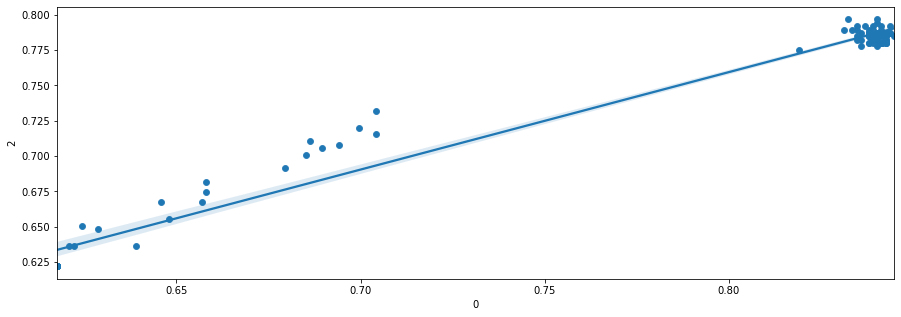

In [193]:
score_board = pd.DataFrame(score_board)
score_board = score_boad.iloc[score_board[2].sort_values(ascending=False).index]

plt.subplots(figsize=(15, 5))
sns.scatterplot(x=score_board.iloc[:, 0], y=score_boad.iloc[:,2])
sns.regplot(x=score_board.iloc[:, 0], y=score_board.iloc[:,2])
plt.show()

In [195]:
score_board.head(20)

,0,1,2
85,0.834647,0.020884,0.791866
42,0.842519,0.025377,0.787081
5,0.842519,0.027753,0.779904
31,0.842519,0.027753,0.784689
74,0.838018,0.019280,0.784689
98,0.833524,0.019946,0.789474
28,0.617546,0.000863,0.622010
64,0.838037,0.023834,0.787081
97,0.844779,0.023129,0.784689
22,0.840278,0.024461,0.779904
